# Supplementary Material for Chapter "Diffusion Models"

This notebooks is a supplement to the chapter "Diffusion Models". This includes examples as well as the exercise solutions

## MNIST Diffusion from Scratch

In this supplemental notebook, we'll train an unconditional diffusion model. We'll use a toy dataset called [MNIST](https://huggingface.co/datasets/mnist), which contains 70,000 28x28 black and white images of handwritten digits. We'll train a diffusion model to generate images of digits resembling this dataset. We'll train with our custom `UNet` first as explained in the `A Simple UNet` section.

### Exploring the data

We begin by loading the data with the `datasets` library.

In [ ]:
from datasets import load_dataset

dataset = load_dataset("mnist")

We make sure the images are the expected size, just as in the chapter. We also visualize a few images to get a sense of the data. Note we do not do random flips (it would not make much sense for digits!) and we use values between 0 and 1 for the pixel values.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms

image_size = 32
batch_size = 8


def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}


dataset.set_transform(transform)

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
    ]
)

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

Input shape: torch.Size([8, 1, 32, 32])


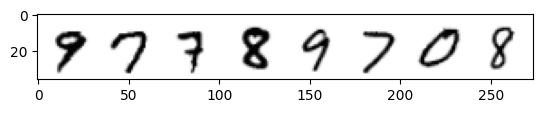

In [ ]:
import torchvision
from matplotlib import pyplot as plt

imgs = next(iter(train_dataloader))["images"]
print("Input shape:", imgs.shape)
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys");

### Corruption

Let's implement a function that will add some amount of configurable noise to the input images. This is the same as in the chapter.

In [ ]:
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

Let's visualize the effect of applying noise to the images.

<matplotlib.image.AxesImage>

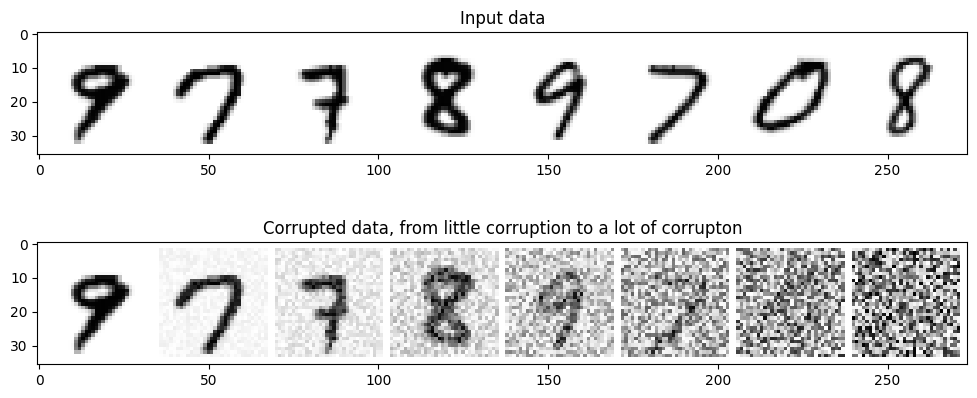

In [ ]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")

# Adding noise (we go from little corruption to a lot)
amount = torch.linspace(0, 1, imgs.shape[0])
noise = torch.rand_like(imgs)
noised_x = corrupt(imgs, noise, amount)

# Plotting the noised version
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

### Basic UNet

We begin by implementing a minimal UNet as described in the book. Some details about this UNet

* Works with single-chanel images, such as grayscale images.
* Has a downscaling and an upscaling path, each with three layers
* Each layer consists on a convolution and an activation (`nn.SiLU`) followed by a downscaling or upscaling step. Note that neither the last layer of the downscaling nor the first layer of the upscaling perform the down or upscaling.
* There are skip connections between downsampling and upsampling blocks.

In [ ]:
import torch
from torch import nn


class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))
        return x

Let's verify that the output shape is the same as the input:

In [ ]:
net = BasicUNet()
x = torch.rand(8, 1, 32, 32)
net(x).shape

torch.Size([8, 1, 32, 32])

### Training model

Let's recall the process. For each training step, we:

1. Load a batch of images,
2. Add noise to the images,
3. Feed the noisy images into the model,
4. Calculate the loss.
5. Backpropagate and update weights with the optimizer.

In [ ]:
from torch.nn import functional as F

device = "cuda"
num_epochs = 3  # How many runs through the data should we do?
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

model = BasicUNet().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        # In the chapter, we use the noise scheduler to manage this
        # as we can pass the timestep. Here, we keep it simple and
        # just sample a random amount of noise to add to the images.
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction
        pred = model(noisy_x)

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        # TODO: if we can change this to actually predicitng noise, that would be
        # nice.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.015965
Finished epoch 1. Average loss for this epoch: 0.010251
Finished epoch 2. Average loss for this epoch: 0.009542


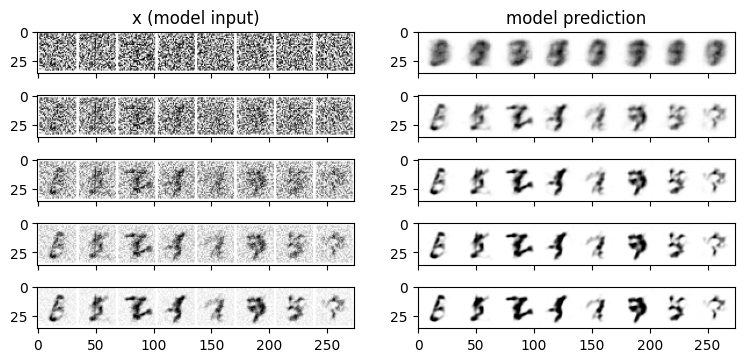

In [ ]:
n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device)  # Start from random
step_history = [x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    # Predict denoise image
    with torch.no_grad():
        pred = model(x)

    # Store output for plotting
    pred_output_history.append(pred.detach().cpu())

    # Move slightly towards that direction
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

    # Store output for plotting
    step_history.append(x.detach().cpu())

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(
        torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys"
    )
    axs[i, 1].imshow(
        torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1),
        cmap="Greys",
    )

<matplotlib.image.AxesImage>

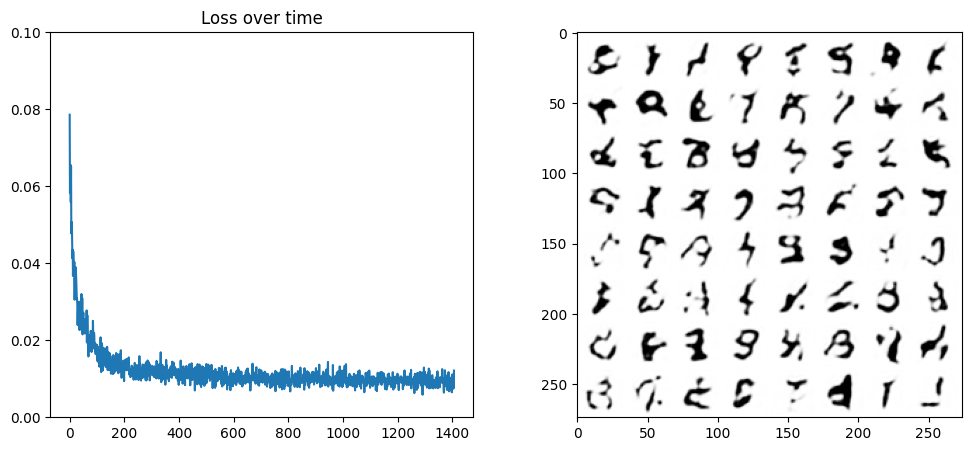

In [ ]:
import torchvision
from matplotlib import pyplot as plt

# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 32, 32).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor
axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)

OK...the generations are not great. Can we do better?

### Diffusers UNet

Let's now use the `diffusers` library UNet implementation. This integrates a couple of additions:

* More parameters (e.g. by having two convolutional layers per block)
* Batch normalization, which helps learn more quickly and reliably.
* Self-attention layers that allow to focus on different pars of the images at different times.

In [ ]:
from diffusers import UNet2DModel

model = UNet2DModel(
    sample_size=32,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
    ),
).to(device)

In [ ]:
sum(
    [p.numel() for p in model.parameters()]
)  # 1.7M vs the ~309k parameters of the BasicUNet

1707009

As this model is larger, the training will take a bit longer.

In [ ]:
batch_size = 128
train_dataloader = DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)
num_epochs = 5

train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
losses = []  # Somewhere to store the loss values for later plotting

# Train the model
for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Load the input images
        clean_images = batch["images"].to(device)

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_x = corrupt(clean_images, noise, noise_amount)

        # Get the model prediction using timestep 0
        pred = model(noisy_x, 0).sample

        # Compare the prediction with the actual image
        # Big note: in the book, we optimize the model to reduce difference
        # the generation and the noise, so the model learns to predict the noise.
        # Here, we calculate the loss between the image and the generation, so the
        # model learns to generate the images directly.
        loss = F.mse_loss(pred, clean_images)

        # Update the model parameters with the optimizer based on this loss
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later plotting
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(
        f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}"
    )

Finished epoch 0. Average loss for this epoch: 0.006592
Finished epoch 1. Average loss for this epoch: 0.005409
Finished epoch 2. Average loss for this epoch: 0.005312
Finished epoch 3. Average loss for this epoch: 0.005112
Finished epoch 4. Average loss for this epoch: 0.004895


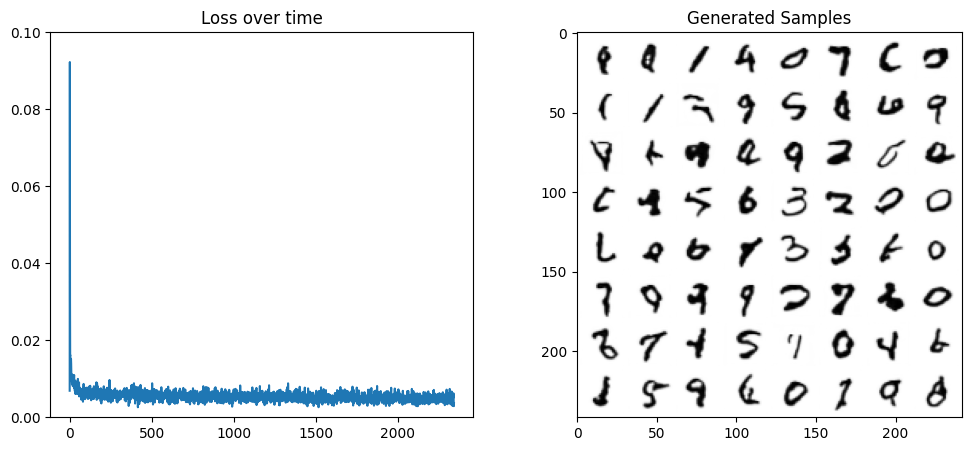

In [ ]:
# Plot losses and some samples
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Losses
axs[0].plot(losses)
axs[0].set_ylim(0, 0.1)
axs[0].set_title("Loss over time")

# Samples
n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),
    cmap="Greys",
)
axs[1].set_title("Generated Samples");

Much better! Still, not perfect, but a great improvement for a model we can quickly train.

## Exercises

A big part of learning is putting your knowledge into practice. We strongly suggest not looking at the answers before taking a serious stab at it. Scroll down for the answers.

n_steps = 40
x = torch.rand(64, 1, 28, 28).to(device)
for i in range(n_steps):
    noise_amount = torch.ones((x.shape[0],)).to(device) * (
        1 - (i / n_steps)
    )  # Starting high going low
    with torch.no_grad():
        pred = model(x, 0).sample
    mix_factor = 1 / (n_steps - i)
    x = x * (1 - mix_factor) + pred * mix_factor

axs[1].imshow(
    torchvision.utils.make_grid(x.detach().cpu(), nrow=8)[0].clip(0, 1),

**1. Explain the diffusion inference algorithm.**

The diffusion inference algorithm is a way to generate samples from a diffusion model. It works as follows:

1. Start with a random sample with the same shape as the data.
2. For each step of the diffusion process, we:
    1. Use the model to predict the noise given the sample.
    2. Update the sample by reducing the noise predicted in the previous step.

In practice, we use the timestep as a parameter to the model to predict the noise. We start with a high noise level and reduce it as we go through the steps.

```python
# Random starting point (4 random images):
sample = torch.randn(4, 3, 64, 64).to(device)

for t in scheduler.timesteps:
    # Get the model prediction
    with torch.no_grad():
        noise_pred = model(sample, t)["sample"]

    # Update sample with step
    sample = scheduler.step(noise_pred, t, sample).prev_sample
```

**2. What's the role of the noise scheduler?**

The noise scheduler is a helper class that define how the noise is added to the images. They receive the output of the diffusion model, a sample, and the current timestep, and return the updated sample.

**3. When creating a training dataset of images, which characteristics are important to watch?**

1. The size of the images. The model must be able to handle images of the same size as the data.
2. The number of channels. For example, grayscale images have one channel, while RGB images have three.
3. The range of the pixel values. The model must be able to handle the range of the pixel values.
4. Wether we should apply any augmentations such as random flips or rotations.

**4. Why do we randomly flip training images?**

Randomly flipping images increases the diversity of the data and makes the model more robust.

**5. How can we evaluate the generations of diffusion models?**

We can evaluate the generations of diffusion models by using metrics such as FID or KID, but they have limitations. Human preference is the gold standard for quality but is more challenging to get.

**6. How do the values of `beta_end` impact the diffusion process?**

`beta_end` controls the end noise value for the noise scheduler. A higher value will result in more noise at the end of the process, which can result in blurrier images. A lower value will result in less noise at the end of the process, which can result in shaper images.

**7. Why do we use UNets rather than VAEs as the main model for diffusion?**

VAEs generate less precise samples. VAEs must reconstruct images from a low-dimensional latent space. On the other hand, UNet skip connections allow information to flow directly from the downsampling blocks to the upsampling blocks, helping make precise predictions and capture high-level information about the image as a whole.

**8. What benefits and challenges are faced when incorporating techniques from transformers (like attention layers or a transformer-based architecture) to diffusion?**

Transformers are more expensive in terms of compute and memory requirements. They have also struggled to scale to very high resolutions. However, they can generate high-quality samples that can lead to lower FID. Transformer-based architcture can also be more scalable backbones for larger models.

Adding attention to the UNet is another option. Self-attention layers allow the model to focus on different parts of the image at different times, which can help the model generate more complex functions. Note that attentions are also more expensive than regular convolutional layers.


9. Show that 

$$ 
\begin{equation}
\mathbf{x}_t =  \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}
\end{equation}
$$

is equivalent to 

$$ 
\begin{equation}
x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{1-\bar{\alpha_t}}\epsilon
\end{equation}
$$

Note that this is not a trivial example. We recommend reviewing [What are Diffusion Models?](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/) for guidance.

We begin by defining $\alpha_t = 1 - \beta_t$. We can then rewrite the first equation as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \mathbf{x}_{t-1} +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

We can now expand $\mathbf{x}_{t-1}$ as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \left( \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{{1-\alpha_{t-1}}} \mathbf{\epsilon} \right) +  \sqrt{{1-\alpha_t}} \mathbf{\epsilon}
\end{equation}
$$

which can be rewritten as:

$$
\begin{equation}
\mathbf{x}_t =  \sqrt{\alpha_t} \sqrt{\alpha_{t-1}} \mathbf{x}_{t-2} +  \sqrt{\alpha}_t \sqrt{{1-\alpha}_{t-1}} \mathbf{\epsilon} +  \sqrt{{1-\alpha}_t} \mathbf{\epsilon}
\end{equation}
$$



Let's now define $\bar{\alpha}_t = \Pi_{s=1}^{t} \alpha_s$ as in the reparametrization trick.


10. This chapter uses the DDPM scheduler, sometimes requiring hundreds or thousands of steps to achieve high-quality results. Recent research has explored achieving good generations with as few steps as possible, down to even one or two! The _diffusers_ library contains multiple schedulers such as the +DDIMScheduler+ from the [Denoising Diffusion Implicit Models](https://arxiv.org/abs/2010.02502) paperfootnote:[Song, Jiaming, et al. Denoising Diffusion Implicit Models. arXiv, 5 Oct. 2022. arXiv.org, https://arxiv.org/abs/2010.02502.] Create some images using the +DDIMScheduler+. This chapter's sampling section required 1000 steps with the +DDPMScheduler+. How many steps are you required to generate images with similar quality? Experiment switching the scheduler for the +google/ddpm-celebahq-256+ and compare both schedulers.